# WaterMeter - François Goujon

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt

## Chargement de toutes les images, on les sauvegardes sous 3 formats :
    - Normal
    - Thresholing OTSU
    - Canny Edge Detection
    
Dans le dossier Data : X_train.npy, X_train_thd.npy, X_train_ced.npy    
On sauvegarde aussi les labels : labels.npy

In [2]:
labelspd = pd.read_csv('index_train.csv', delimiter=',')
ids = labelspd['ID'].values
labels = labelspd['index'].values
print(ids[0], labels[0])

0127d0 1416


In [3]:
#  thresholding avec valeur de seuil automatique via optimisation OTSU
def thresholdingOTSU(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#canny edge detection
def canny(image, t1 = 100, t2= 400, ap = 3):
    return cv2.Canny(image, t1, t2, apertureSize = ap)
# grayscale 
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def loadpictures(rep_path, ids):
    train = []
    train_THD = []
    train_CED = []
    for new_file in tqdm.tqdm(ids):
        new_file = new_file + '.jpg'
        path_img = os.path.join(rep_path , new_file)
        x = cv2.imread(path_img)
        img = cv2.resize(x,(512,512))
        train.append(img)
        
        gray = get_grayscale(img)
            
        thd = thresholdingOTSU(gray)
        train_THD.append(thd)
            
        ced = canny(gray)
        train_CED.append(ced)
      
    X_train = np.array(train)
    X_train_thd = np.array(train_THD)
    X_train_ced = np.array(train_CED)
    
    return X_train, X_train_thd, X_train_ced

In [4]:
X_train, X_train_thd, X_train_ced = loadpictures('pictures/', ids)
print(X_train.shape)
print(X_train_thd.shape)
print(X_train_ced.shape)

100%|██████████| 793/793 [01:02<00:00, 12.77it/s]


(793, 512, 512, 3)
(793, 512, 512)
(793, 512, 512)


In [26]:
X_train = (X_train - 127.5)/127.5   # pixel dans [0, 255] --> [-1,1]

In [27]:
np.save('Data/labels.npy', labels)
np.save('Data/X_train.npy', X_train)
np.save('Data/X_train_thd.npy', X_train_thd)
np.save('Data/X_train_ced.npy', X_train_ced)

## Chargement images entraînement modele YOLO (avec bouding boxes)

In [6]:
# On fait une liste avec le path de chaque image et une liste avec le path de chaque label (boite)
image_path = 'Datayolo/images/'
gt_path = 'Datayolo/ground_truth/'
def getpaths(rep_path):
    train_image_paths = []
    train_gt_paths = []
    train_id = []
    for new_file in tqdm.tqdm(os.listdir(rep_path)):
        if new_file != ".DS_Store":
            name_split = new_file.split('.')
            image_name = name_split[0]
            train_id.append(image_name)
            image_name = image_name + '.jpg'

            path_img = os.path.join(image_path , image_name)
            train_image_paths.append(path_img)
            train_gt_paths.append(os.path.join(rep_path , new_file))
    return train_image_paths, train_gt_paths, train_id

In [7]:
#Contenu des listes
train_image_paths , train_gt_paths, train_id = getpaths(gt_path)
print(train_image_paths[0])
print(train_gt_paths[0])
print(train_id[0])

100%|██████████| 33/33 [00:00<00:00, 103679.42it/s]

Datayolo/images/1f09ce.jpg
Datayolo/ground_truth/1f09ce.txt
1f09ce


In [8]:
# Essai formatage ground truth
file = "Datayolo/ground_truth/1f09ce.txt"
name = open(file , 'r')
data = name.read()
print(data)
data = data.split("\n")
print(data)
data = data[:-1]
print(data)

670 2130 2110 2450 "0111681"

['670 2130 2110 2450 "0111681"', '']
['670 2130 2110 2450 "0111681"']


#### Pour les bounding box, on va associer à chaque image une matrice Y de taille N x N tel que Y[i][j] soit égal à 1 si une bouding box à son centre

In [9]:
X_final = []
Y_final = []
grid_h = 16   # on découpe l'image en une grille 16x16 pour les box
grid_w = 16
img_w = 512   # les images seront resize en 512x512
img_h = 512

In [10]:
for z in tqdm.tqdm(range(len(train_image_paths))):
    
    new_file = train_image_paths[z]
    print(new_file)
    x = cv2.imread(train_image_paths[z])
    x_sl = 512/x.shape[1]         # Ratio d'aggrandissement de l'image (<1 en principe car les images sont plus
    y_sl = 512/x.shape[0]         # grandes que 512x512), shape : (hauteur, largeur, canaux(bgr))
    
    img = cv2.resize(x,(512,512))
    X_final.append(img)
    
    # Format fichier gt : 
    # (distance cote gch boite à cote gch image, distance haut boite à haut image,
    #    distance cote droit boite à gauche gch image, distance bas boite à haut image)
    
    i = " "        # fichier id.txt au format (x y z w "nom")
    
    Y = np.zeros((grid_h,grid_w,1,5))    # On crée la matrice
    
    file = train_gt_paths[z]
    name = open(file , 'r')
    data = name.read()
    data = data.split("\n")
    data = data[:-1]     # permet d'enlever la dernière ligne qui est vide.
    
    for li in data:
        file_data = li.split(i)
        strr = file_data[4]   # On récupère le mot
        box = file_data[:4]    # et les coordonnées de la boite
        
        xmin = int(box[0])*x_sl     # On ajuste les coordonnées pour qu'elles correspondent au resize
        xmax = int(box[2])*x_sl
        ymin = int(box[1])*y_sl
        ymax = int(box[3])*y_sl
        
        w = (xmax - xmin)/img_w          # ratio largeur de la boite
        h = (ymax - ymin)/img_h          # ratio hauteur de la boite
        
        x = ((xmax + xmin)/2)/img_w      # milieu de la boite (x*img_w,y*img_h)
        y = ((ymax + ymin)/2)/img_h
        x = x * grid_w                   # coordonnées de la boite dans la grille (partie entière)
        y = y * grid_h
        
        Y[int(y),int(x),0,0] = 1
        Y[int(y),int(x),0,1] = x - int(x)
        Y[int(y),int(x),0,2] = y - int(y)
        Y[int(y),int(x),0,3] = w
        Y[int(y),int(x),0,4] = h
        
    Y_final.append(Y)

  3%|▎         | 1/32 [00:00<00:06,  5.07it/s]

Datayolo/images/1f09ce.jpg
Datayolo/images/1ba26b.jpg


 12%|█▎        | 4/32 [00:00<00:04,  6.60it/s]

Datayolo/images/5d3605.jpg
Datayolo/images/7bf2e3.jpg
Datayolo/images/2e5f8d.jpg


 19%|█▉        | 6/32 [00:00<00:03,  7.37it/s]

Datayolo/images/1a3c33.jpg
Datayolo/images/0c429f.jpg
Datayolo/images/1ec531.jpg
Datayolo/images/8f18cb.jpg
Datayolo/images/0c5ec4.jpg


 38%|███▊      | 12/32 [00:00<00:01, 10.92it/s]

Datayolo/images/8fb787.jpg
Datayolo/images/5c708e.jpg
Datayolo/images/0d55b5.jpg


 44%|████▍     | 14/32 [00:01<00:01, 10.09it/s]

Datayolo/images/8d929e.jpg
Datayolo/images/4aefa8.jpg
Datayolo/images/7f8ec9.jpg
Datayolo/images/1aa5db.jpg


 66%|██████▌   | 21/32 [00:01<00:00, 13.87it/s]

Datayolo/images/5c7106.jpg
Datayolo/images/2ee109.jpg
Datayolo/images/3beb85.jpg
Datayolo/images/3af34b.jpg
Datayolo/images/1df3e4.jpg
Datayolo/images/0cee7a.jpg


 78%|███████▊  | 25/32 [00:01<00:00, 13.19it/s]

Datayolo/images/6caf66.jpg
Datayolo/images/7bbb2d.jpg
Datayolo/images/7e609e.jpg
Datayolo/images/6ad7e9.jpg


100%|██████████| 32/32 [00:02<00:00, 15.53it/s]

Datayolo/images/0cfa42.jpg
Datayolo/images/6a09b5.jpg
Datayolo/images/03e8fc.jpg
Datayolo/images/4b1339.jpg
Datayolo/images/1e157c.jpg


In [11]:
X = np.array(X_final)
X_final = []
Y = np.array(Y_final)
Y_final = []

X = (X - 127.5)/127.5

In [12]:
print(X.shape)
print(Y.shape)

(32, 512, 512, 3)
(32, 16, 16, 1, 5)


In [13]:
np.save('Datayolo/X.npy',X)
np.save('Datayolo/Y.npy',Y)
np.save('Datayolo/train_id.npy', train_id)

### Visualisation avec cadre

In [11]:
def bgrToRgb(image):
    b,g,r = cv2.split(image)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

def showimage(path_image, path_gt):
    image = cv2.imread(path_image)
    x_sl = 512/image.shape[1]        
    y_sl = 512/image.shape[0]         
    img = cv2.resize(image,(512,512))
    i = " " 
    if 'img' in path_gt:
        i = ", " 
    
    name = open(path_gt , 'r')
    data = name.read()
    data = data.split("\n")
    data = data[:-1]    
    
    for li in data:
        file_data = li.split(i)
        strr = file_data[4]   
        box = file_data[:4]    
        
        xmin = int(box[0])*x_sl     
        xmax = int(box[2])*x_sl
        ymin = int(box[1])*y_sl
        ymax = int(box[3])*y_sl
        bbimg = cv2.rectangle(img,(int(xmin),int(ymin)),(int(xmax),int(ymax)) , color = (0,255,0))
        
    plt.imshow(bgrToRgb(bbimg))
    plt.show()

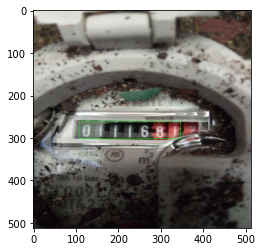

In [12]:
showimage("Datayolo/images/1f09ce.jpg", "Datayolo/ground_truth/1f09ce.txt")

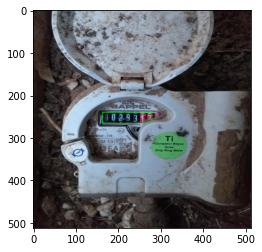

In [13]:
showimage("Datayolo/images/1aa5db.jpg", "Datayolo/ground_truth/1aa5db.txt")